# 1D Burgers' equation, finite volume, reconstructed upwind scheme

_Gilbert François Duivesteijn_

In [1]:
%%javascript
MathJax.Hub.Config({
    TeX: { equationNumbers: { autoNumber: "AMS" } }
});

<IPython.core.display.Javascript object>

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
from scipy.integrate import odeint
from scipy.linalg import toeplitz

from IPython import display

## Non linear partial differential equation

Let's examin the pde
\begin{align}\label{eq:pde1}
\frac{\partial u}{\partial t} + \frac{\partial f(u)}{\partial x} = 0.
\end{align}
With
\begin{align}
f(u) \equiv u
\end{align}
we have the convection equation, a linear equation which can be solved with finite difference. Examples of how to solve these type of equations is given in the notebook(s) "1D wave equation, finite difference, ...".  When
\begin{align}
f(u) \equiv \frac{1}{2}u^2
\end{align}
the equation is non linear and cannot be solved with finite difference anymore. This specific non-linear equation is known as the (inviscid) Burgers' equation.

Burgers' equation or Bateman–Burgers equation is a fundamental partial differential equation occurring in various areas of applied mathematics, such as fluid mechanics, nonlinear acoustics, gas dynamics, and traffic flow. The equation was first introduced by Harry Bateman in 1915 and later studied by Johannes Martinus Burgers in 1948 [1].

For a given field $u(x,t)$ and diffusion coefficient (or kinematic viscosity, as in the original fluid mechanical context) $\nu$ , the general form of Burgers' equation (also known as viscous Burgers' equation) in one space dimension is the dissipative system:

\begin{align}
\frac{\partial u}{\partial t} + \frac{\partial f(u)}{\partial x} &= \nu\frac{\partial^2 u}{\partial x^2} .\\
\end{align}

When the diffusion term is absent (i.e. $\nu=0$), Burgers' equation becomes the inviscid Burgers' equation (\ref{eq:pde1}).



## Compute flux with the integral form

Using the primitive form , with $f(u) = \frac{u^2}{2}$ and applying the chain rule, we can write the Burgers' equation as

\begin{align}
\frac{\partial u}{\partial t} + \frac{\partial f}{\partial u} \frac{\partial u}{\partial x} &= 0 \\
\frac{\partial u}{\partial t} + u\frac{\partial u}{\partial x} &= 0. \\
\end{align}

where $\frac{\partial f(u)}{\partial u}$ can be seen as the local wave speed.


Writing the Burgers' equation in integral form
\begin{align}
\int_{a}^{b} \left( \frac{\partial u}{\partial t} + \frac{\partial f(u)}{\partial x} \right)dx &= 0 \\
\frac{d}{dt} \int_{a}^{b} udx + \left. f(u) \right|_a^b &= 0
\end{align}

Bringing the $f(u)$ term to the other side
\begin{align}\label{eq:burgers_int}
\frac{d}{dt} \int_{a}^{b} udx &= f(u(a)) - f(u(b))
\end{align}

For example if $u$ is denoted as the density, then the integral of $u$ over the spacial domain $\int_{a}^{b} udx$ means the total amount of mass inside this range and $\frac{d}{dt}$ is the rate of change.

In words the integral form of the Burgers' equation (\ref{eq:burgers_int}) can be described as:

>The rate of change of mass inside a volume is equal to the rate of flux going into the volume minus the rate of flux going out of the volume.

Substituting $f(u) = \frac{u^2}{2}$ into (\ref{eq:burgers_int}) gives

\begin{align}\label{eq:burgers_int2}
\frac{d}{dt} \int_{a}^{b} udx + \frac{u(b)^2}{2} - \frac{u(a)^2}{2} &= 0
\end{align}

[1] [Burgers' equation](https://en.wikipedia.org/wiki/Burgers%27_equation)

## Upwind flux scheme

```
  +------+------+------+------+------+--/ /-+------+------+------+------+
  |  U0  |  U1  |      |      |      |  \ \ |      |      |      |  Un  |
  |      |      |      |      |      |  / / |      |      |      |      |
  +------+------+------+------+------+--\ \-+------+------+------+------+
  :  i=0 :  i=1                                            i=n-1    i=n
  :      :
  :      :
i-1/2  i+1/2    
```

Let's try to write (\ref{eq:burgers_int2}) in such a way, that we can solve the equation. Start with dividing the whole equation by $(b-a)$:

\begin{align}\label{eq:burgers_int3}
\frac{\frac{d}{dt} \int_{a}^{b} udx + f(u(b)) - f(u(a))}{b - a} &\Rightarrow \\
\frac{d}{dt} \left( \frac{1}{\Delta x}\int_{a}^{b} udx \right) + \frac{f(u(b)) - f(u(a))}{\Delta x}
\end{align}

where $(b-a) = \Delta x$.



For the 1D case, when denoting the cells as $i$ from $0$ to $n$, the cell interfaces $a$ and $b$ on the left and right hand side are denoted as $i-\frac{1}{2}$ and $i+\frac{1}{2}$. The state $\bar{u}_i$ is the average of $u$ inside a volume, defined by

\begin{align}
\bar{u}_i &= \frac{1}{\Delta x}\int_{a}^{b} u dx \\
          &= \frac{1}{\Delta x}\int_{x_{i-\frac{1}{2}}}^{x_{i+\frac{1}{2}}} u dx \\
\end{align}


Now we can write e.g. the flux at the right interface of cell $i$ as

\begin{align}
f_{i+\frac{1}{2}} &= \frac{\bar{f}_i + \bar{f}_{i+1}}{2} \qquad \forall \quad \bar{f}_i = f(\bar{u}_i).\\
\end{align}

The equation to solve is

\begin{align}
\frac{\partial \bar{u}_i}{\partial t} = \frac{f_{i-\frac{1}{2}}  - f_{i+\frac{1}{2}}}{\Delta x}
\end{align}

Now, instead of taking the central average around a cell boundary, we take the flux from the upwind direction only. To compute the shock speed at the cell interface, we do

\begin{align}
s_{i+\frac{1}{2}} = \frac{\bar{u}_i + \bar{u}_{i+1}}{2}
\end{align}

The flux at interface $i+\frac{1}{2}$ becomes

\begin{align}
f_{i+\frac{1}{2}} = 
\left\{ 
\begin{array}{l l l}
\bar{f}_i & \textrm{where} & s_{i+\frac{1}{2}} > 0, \\
\bar{f}_{i+1} & \textrm{where} & s_{i+\frac{1}{2}} < 0,
\end{array}
\right.
\end{align}

## Reconstruction of the upwind scheme

In order to make the upwind scheme 2nd order accurate, we can interpolate the state in each cell towards its cell interfaces. Instead of having a constant $u_i$ over the whole cell, we have a linear function describing the cell state.

```
--+--------------------------+--------------------------+--------------------------+--
  |                          |                          |                          |
  | u[i-1]   u[i-1]   u[i-1] | u[i]      u[i]    u[i]   | u[i+1]   u[i+1]   u[i+1] |
  | _left             _right | _left             _right | _left             _right |
  |                          |                          |                          |
--+--------------------------+--------------------------+--------------------------+--
             Delta x                    Delta x                    Delta x          
```


To compute the $u$ at the cell boundaries, we compute first the slope $\frac{\partial u}{\partial x}$ in the middle of the cell with central difference scheme:

\begin{align}
\left.\frac{du}{dx}\right|_{i} = \frac{u_{i+1} - u_{i-1}}{2\Delta x}
\end{align}

Then we can compute the state $u$ at each cell boundary:
\begin{align}
u_{i_{right}} &= u_i + \frac{\partial u_i}{\partial x}\cdot \frac{\Delta x}{2} \\
u_{i_{left}} &= u_i - \frac{\partial u_i}{\partial x}\cdot \frac{\Delta x}{2},
\end{align}

the flux at the cell boundaries (for the Burgers' equation)

\begin{align}
f_{i_{right}} &= \frac{u_{i_{right}}^2}{2} \\
f_{i_{left}} &= \frac{u_{i_{left}}^2}{2}, \\
\end{align}

and the shock speed at each cell boundary:

\begin{align}
s_{i+\frac{1}{2}} &= \frac{u_{i} + u_{i+1}}{2}
\end{align}

The flux at boundary $i+\frac{1}{2}$ becomes

\begin{align}
f_{i+\frac{1}{2}} = 
\left\{ 
\begin{array}{l l l}
f_{{i}_{right}} & \textrm{where} & s_{i+\frac{1}{2}} > 0, \\
f_{{(i+1)}_{left}} & \textrm{where} & s_{i+\frac{1}{2}} < 0,
\end{array}
\right.
\end{align}

_Note that with the reconstructed upwind scheme, the solution is **unstable**, when a shock wave appears. One reason is that the $\frac{\partial u}{\partial x}$ to reconstruct $u_i$ around the cell interface is using central difference across the shock._

In [3]:
# number of cells in 1D space
n = 200
u = np.zeros(shape=(n,))

# space
x0 = 0
xn = 1
dx = (xn - x0)/n
x_interface = np.linspace(x0, xn, n+1)
x = x_interface[0:n] + dx/2

# time
t0 = 0
tn = .5
t_steps = 200
t = np.linspace(t0, tn, t_steps)


# Initial condition
u_init = np.sin(2*np.pi*x)

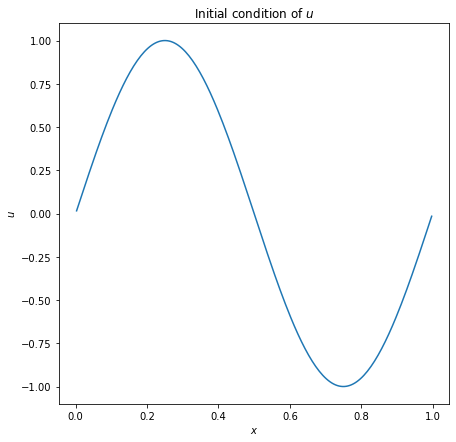

In [4]:
plt.figure(figsize=(7,7))
plt.plot(x, u_init, label="$\bar{u}$")
plt.xlabel("$x$")
plt.ylabel("$u$")
plt.title("Initial condition of $u$")
plt.show()

In [5]:
def dudt_rec_upwind(u, t, dx):
    # u denotes state in cell centers (in the formulas sometimes written as \bar{u})
    # f denotes f(u) in cell centers, using Burgers' equation f(u) = u^2/2
    n = u.shape[0]
    
    # du/dx in cell centers, second order in the inner domain, first order at the edges of the computational domain.
    dudx = np.zeros_like(u)
    dudx[1:n-1] = (u[2:n] - u[0:n-2])/(2*dx)
    dudx[0] = (u[1] - u[0])/dx
    dudx[n-1] = (u[n-1] - u[n-2])/dx

    # Compute the interpolated cell values at the right and left hand side of the cell.
    # --+--------------------------+--------------------------+--------------------------+--
    #   |                          |                          |                          |
    #   | u[i-1]   u[i-1]   u[i-1] | u[i]      u[i]    u[i]   | u[i+1]   u[i+1]   u[i+1] |
    #   | _left             _right | _left             _right | _left             _right |                              |                              |
    #   |                          |                          |                          |
    # --+--------------------------+--------------------------+--------------------------+--

    u_right = u + dudx*dx/2
    u_left = u - dudx*dx/2
    
    # Compute the flux for every cell i, not in the middle, but at every cell interface _inside_ each cell.
    f_right = u_right**2 / 2
    f_left = u_left**2 / 2
    
    # Shock speed at the cell interfaces from f_{0-1/2} to f_{n+1/2}, 
    # setting the outer boundaries of the domain to s=0, because they are unused.
    s = np.zeros(shape=(n+1,))
    s[1:n] = (u_right[0:n-1] + u_left[1:n]) / 2
    
    # Flux at the cell interfaces from f_{0-1/2} to f_{n+1/2}
    f_interface = np.zeros(shape=(n+1,))
    assert f_interface.shape[0] == u.shape[0] + 1

    # left boundary f_{0-1/2}
    f_interface[0] = 0
    
    for i in range(1, n):
        if s[i] > 0:
            f_interface[i] = f_right[i-1]
        else:
             f_interface[i] = f_left[i]
    
    # right boundary f_{n+1/2}
    f_interface[n] = 0
    
    # Compute the time derivative as the difference of flux directed into the cell.
    du_dt = (f_interface[0:n] - f_interface[1:n+1])/dx
    return du_dt

In [6]:
u = odeint(dudt_rec_upwind, u_init, t, args=(dx,))

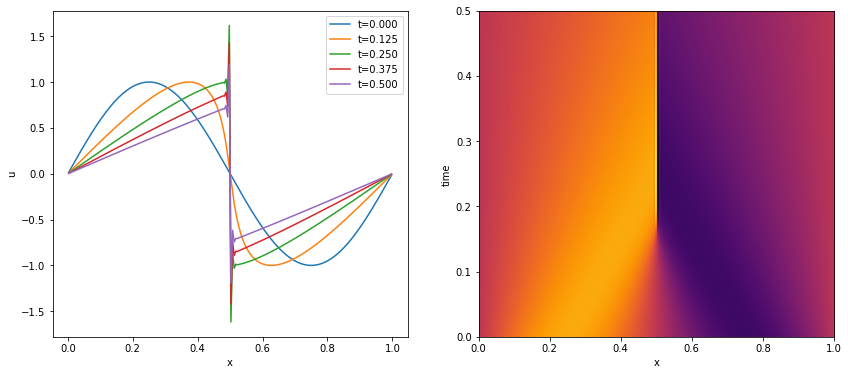

In [7]:
fig, axs = plt.subplots(1, 2, figsize=(14, 6))
#axs[0].set_ylim(min(U0, Un),max(U0,Un))
axs[0].plot(x, u[0], label=f"t={0/t_steps*(tn-t0):.3f}")
axs[0].plot(x, u[49], label=f"t={50/t_steps*(tn-t0):.3f}")
axs[0].plot(x, u[99], label=f"t={100/t_steps*(tn-t0):.3f}")
axs[0].plot(x, u[149], label=f"t={150/t_steps*(tn-t0):.3f}")
axs[0].plot(x, u[199], label=f"t={200/t_steps*(tn-t0):.3f}")
axs[0].legend()
axs[0].set_ylabel("u")
axs[0].set_xlabel("x")
axs[1].imshow(u, aspect="auto", cmap="inferno", origin="lower", extent=[0, 1, t0, tn])
axs[1].set_xlabel(f"x")
axs[1].set_ylabel("time")
plt.show()

In [8]:
# Animation of the solution over the integrated time span.

def animate(frame):
    y = u[frame]
    line.set_data((x, y))
    plt.title(f"t={tn * frame / t_steps:0.2f}")

    
fig = plt.figure(figsize=(6, 6))
lines = plt.plot([])
line = lines[0]
plt.xlim([x0, xn])
plt.ylim([-1.1, 1.1])
plt.xlabel("x")
plt.ylabel("u")
plt.title("")
  
anim = FuncAnimation(fig, animate, frames=t_steps, interval=50)
video = anim.to_html5_video()
html = display.HTML(video)
display.display(html)
plt.close()